In [1]:
import sys

sys.executable.split('/')[-3] == 'cda_venv'

True

In [2]:
import math
import os
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

np.random.seed(2021)
plt.style.use('ggplot')  # fivethirtyeight seaborn-dark-palette
warnings.filterwarnings('ignore')

## Data loading

In [3]:
data_dir = 'data'
passengers_file = 'AirPassengers.csv'

data = pd.read_csv(os.path.join(data_dir, passengers_file), parse_dates=['Month'])  # , index_col='Month'

data['year'] = data['Month'].dt.year
data['month'] = data['Month'].dt.month

## Data description

In [4]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
 2   year         144 non-null    int64         
 3   month        144 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.6 KB
None


,Month,#Passengers,year,month
0,1949-01-01,112,1949,1
1,1949-02-01,118,1949,2
2,1949-03-01,132,1949,3
3,1949-04-01,129,1949,4
4,1949-05-01,121,1949,5


In [5]:
data.groupby('year').describe()['#Passengers'].T

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.00000,12.000000,12.000000,12.000000,12.000000
mean,126.666667,139.666667,170.166667,197.000000,225.000000,238.916667,284.000000,328.25000,368.416667,381.000000,428.333333,476.166667
std,13.720147,19.070841,18.438267,22.966379,28.466887,34.924486,42.140458,47.86178,57.890898,64.530472,69.830097,77.737125
min,104.000000,114.000000,145.000000,171.000000,180.000000,188.000000,233.000000,271.00000,301.000000,310.000000,342.000000,390.000000
25%,118.000000,125.750000,159.000000,180.750000,199.750000,221.250000,260.750000,300.50000,330.750000,339.250000,387.500000,418.500000
50%,125.000000,137.500000,169.000000,192.000000,232.000000,231.500000,272.000000,315.00000,351.500000,360.500000,406.500000,461.000000
75%,135.250000,151.250000,179.500000,211.250000,238.500000,260.250000,312.750000,359.75000,408.500000,411.750000,465.250000,514.750000
max,148.000000,170.000000,199.000000,242.000000,272.000000,302.000000,364.000000,413.00000,467.000000,505.000000,559.000000,622.000000


In [6]:
# data_cp -> Index: 'Month'
data_full = data.copy()
data_full.set_index('Month', inplace=True)

# data to EDA without test
test_size = 12
data = data.iloc[:-test_size]# .reset_index()

# data_cp -> Index: 'Month'
data_cp = data.copy()
data_cp.set_index('Month', inplace=True)

## Visualizations

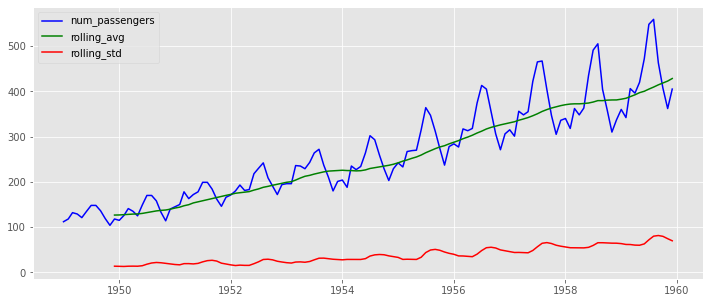

In [7]:
window = 12

plt.figure(figsize=(12,5))
rolling_avg = data_cp['#Passengers'].rolling(window=window).mean()
rolling_std = data_cp['#Passengers'].rolling(window=window).std()

plt.plot(data_cp['#Passengers'], color='b', label='num_passengers')
plt.plot(rolling_avg, color='g', label='rolling_avg')
plt.plot(rolling_std, color='r', label='rolling_std')
plt.legend()

plt.show()

Data - rolling_avg

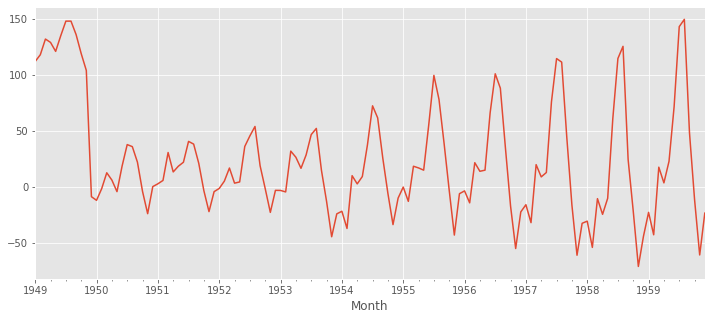

In [8]:
(data_cp['#Passengers'] - rolling_avg.fillna(0)).plot(figsize=(12,5));

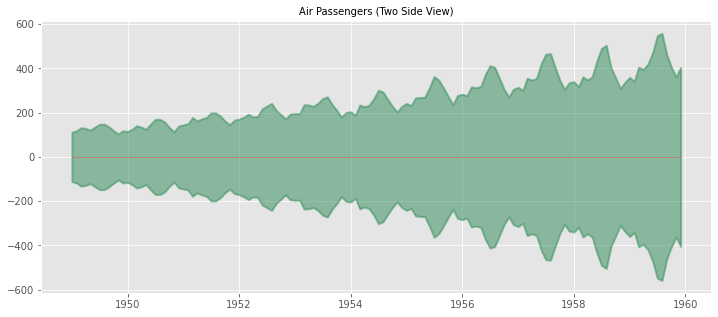

In [9]:
# Plot
# fig, ax = plt.subplots(1, 1, figsize=(10,3), dpi=120)
plt.figure(figsize=(12,5))
plt.fill_between(
    data['Month'], 
    y1=data['#Passengers'], 
    y2=-data['#Passengers'], 
    alpha=0.5, 
    linewidth=2, 
    color='seagreen'
)

# plt.ylim(-800, 800)
plt.hlines(
    y=0, 
    xmin=np.min(data['Month']), 
    xmax=np.max(data['Month']), 
    linewidth=.5
)
plt.title('Air Passengers (Two Side View)', fontsize=10)

plt.show()

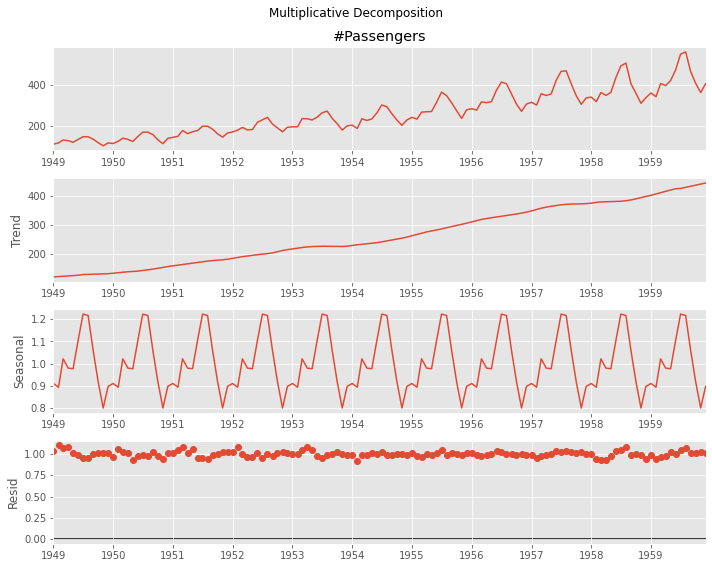

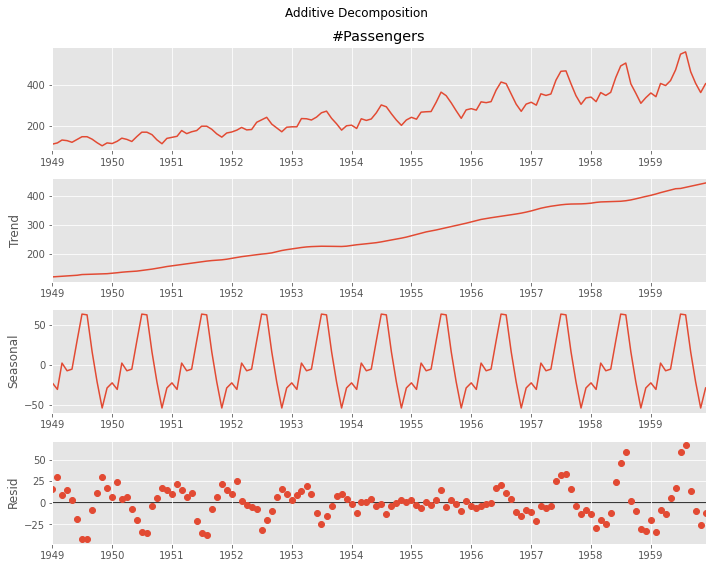

In [10]:
period = 12

# Setting extrapolate_trend='freq' takes care of any missing values in the trend and residuals at the beginning of the series.

# multiplicative decomposition 
multiplicative_decomposition = seasonal_decompose(
    data_cp['#Passengers'], 
    model='multiplicative', 
    # period=period,
    extrapolate_trend='freq'
)

# additive decomposition
additive_decomposition = seasonal_decompose(
    data_cp['#Passengers'], 
    model='additive', 
    # period=period,
    extrapolate_trend='freq'
)

# plot
plt.rcParams.update({'figure.figsize': (10,8)})
# plt.figure(figsize=(12,5))
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition')
plt.tight_layout(rect=[0, 0, 1, 1])

additive_decomposition.plot().suptitle('Additive Decomposition')
plt.tight_layout(rect=[0, 0, 1, 1])

plt.show()

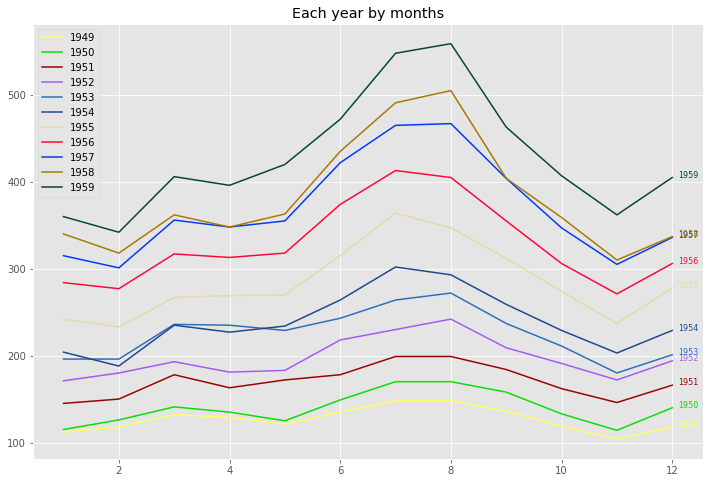

In [11]:
years = data['year'].unique()

# prepare color
np.random.seed(30)
colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# plot
plt.figure(figsize=(12,8))
for color_id, year in enumerate(years):
    plt.plot(
        data[data['year'] == year]['month'],
        data[data['year'] == year]['#Passengers'], 
        label=year,
        color=colors[color_id]
    )
    plt.text(
        data[data['year'] == year].shape[0]+0.1, 
        data[data['year'] == year]['#Passengers'][-1:].values[0], 
        year, 
        fontsize=8, 
        color=colors[color_id]
    )

plt.gca().set(title="Each year by months")
plt.legend(loc='upper left')
plt.show()

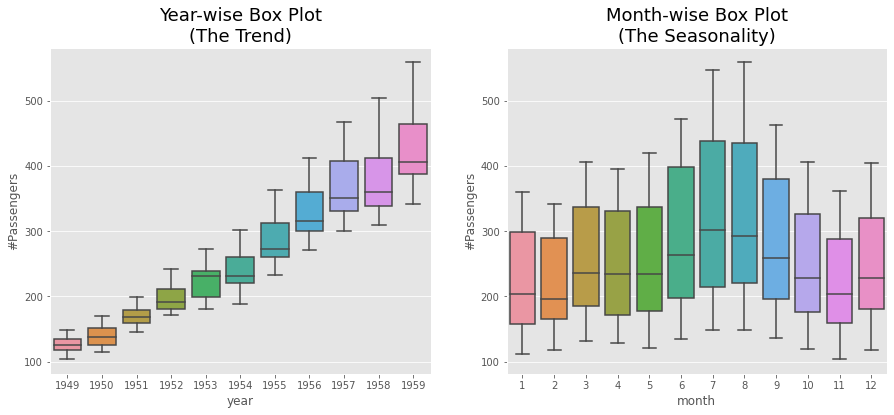

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

sns.boxplot(
    x='year', 
    y='#Passengers', 
    data=data, 
    ax=axes[0]
)
sns.boxplot(
    x='month', 
    y='#Passengers', 
    data=data
)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)

plt.show()

## Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

- Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

- Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

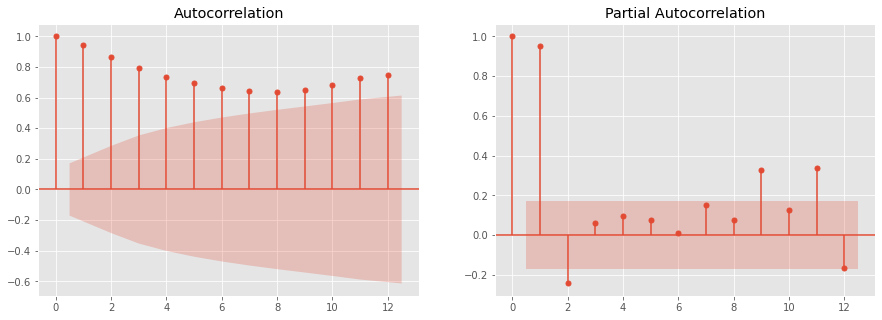

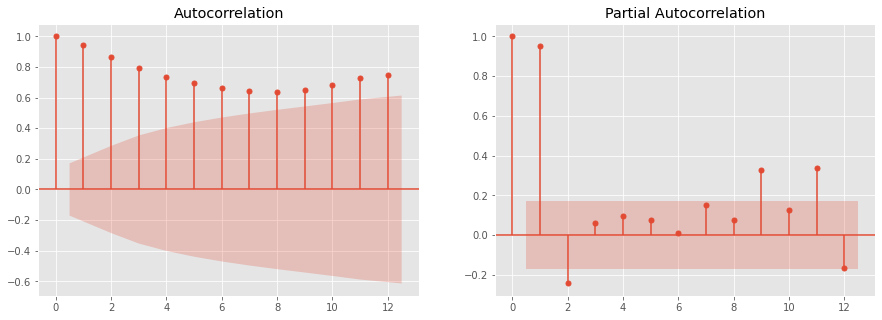

In [13]:
lags=12

fig, axes = plt.subplots(1, 2, figsize=(15,5))
plot_acf(data['#Passengers'].tolist(), lags=lags, ax=axes[0])
plot_pacf(data['#Passengers'].tolist(), lags=lags, ax=axes[1])

# Forecasting - LSTM

### Train test split

In [14]:
def x_y_split(ds, look_back=1):
    x, y = [], []
    for i in range(len(ds)-look_back):
        end_idx = i + look_back
        x.append(
            ds[i:end_idx]
        )
        y.append(
            ds[end_idx]
        )
    return np.array(x), np.array(y)


# def train_test_split(ds, test_size=12, split_x_y=False, look_back=1):
#     train_size = ds.shape[0] - test_size

#     data_train = ds[0:train_size, :]
#     data_test = ds[train_size:, :]

#     if split_x_y:

#         data_train = x_y_split(
#             ds=data_train,
#             look_back=look_back
#         )
#         data_test = x_y_split(
#             ds=data_test,
#             look_back=look_back
#         )

#     return data_train, data_test


def df_train_test_split(df, test_size=12):
    data_train = df.iloc[:-test_size]# .reset_index()
    data_test = df.iloc[-test_size:]# .reset_index()

    return data_train, data_test

In [15]:
test_size = 12
look_back = 12
n_features = 1

df_train, df_test = df_train_test_split(
    df=data_full['#Passengers'].to_frame(),
    test_size=test_size
)

train_seq = df_train['#Passengers'].values
test_seq = df_test['#Passengers'].values

x_train, y_train = x_y_split(
    ds=train_seq,
    look_back=look_back
)

# reshape from [samples, timesteps] into [samples, timesteps, features]
x_train = x_train.reshape(
    (x_train.shape[0],
    x_train.shape[1],
    n_features)
)

### Prepare model

In [16]:
model = Sequential()
model.add(
    LSTM(
        50, 
        activation='relu', 
        input_shape=(look_back, n_features)
    )
)
model.add(Dense(1))
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


### Fit model to train set

In [17]:
epochs = 250

model.fit(
    x_train, 
    y_train,
    epochs=epochs
)

Epoch 6/250
4/4 [==============================] - 0s 4ms/step - loss: 1133.5552
Epoch 7/250
4/4 [==============================] - 0s 4ms/step - loss: 1140.7856
Epoch 8/250
4/4 [==============================] - 0s 4ms/step - loss: 1089.6274
Epoch 9/250
4/4 [==============================] - 0s 5ms/step - loss: 960.8488
Epoch 10/250
4/4 [==============================] - 0s 5ms/step - loss: 793.4169
Epoch 11/250
4/4 [==============================] - 0s 5ms/step - loss: 746.8682
Epoch 12/250
4/4 [==============================] - 0s 6ms/step - loss: 731.4912
Epoch 13/250
4/4 [==============================] - 0s 4ms/step - loss: 662.8281
Epoch 14/250
4/4 [==============================] - 0s 5ms/step - loss: 2281.6125
Epoch 15/250
4/4 [==============================] - 0s 4ms/step - loss: 27813.6582
Epoch 16/250
4/4 [==============================] - 0s 7ms/step - loss: 41924.6523
Epoch 17/250
4/4 [==============================] - 0s 4ms/step - loss: 32984.0469
Epoch 18/250
4/4 [====

### Make predictions

In [18]:
# predict 12* one sample
seq = train_seq[-look_back:]
predictions = []
for i in range(test_size):
    x_input = seq[-look_back:]
    x_input = x_input.reshape(
        (1, 
        look_back, 
        n_features)
    )
    y_pred = model.predict(x_input, verbose=0)
    seq = np.append(seq, y_pred[0])
    predictions.append(int(y_pred[0][0]))

df_test['prediction'] = predictions

### Metrics and results

In [19]:
# calculate metrincs
precision = 3
print('Test Set Scores:')

print(f'RMSE: {round(math.sqrt(mean_squared_error(test_seq, predictions)), precision)}')
print(f'MAE: {round(mean_absolute_error(test_seq, predictions), precision)}')
print(f'MAPE: {round(mean_absolute_percentage_error(test_seq, predictions), precision)}')

Test Set Scores:
RMSE: 16.039
MAE: 11.583
MAPE: 0.025


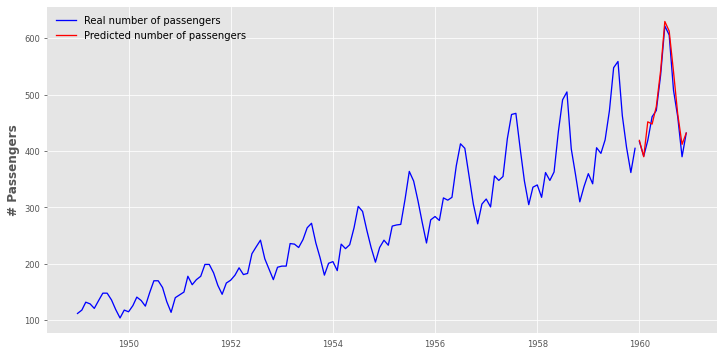

In [20]:
plt.figure(figsize=(12,6))
plt.plot(df_train['#Passengers'], color='b')
plt.plot(df_test['#Passengers'], color='b', label='Real number of passengers')
plt.plot(df_test['prediction'], color='r', label='Predicted number of passengers')
plt.ylabel('# Passengers')
plt.legend()
plt.show()

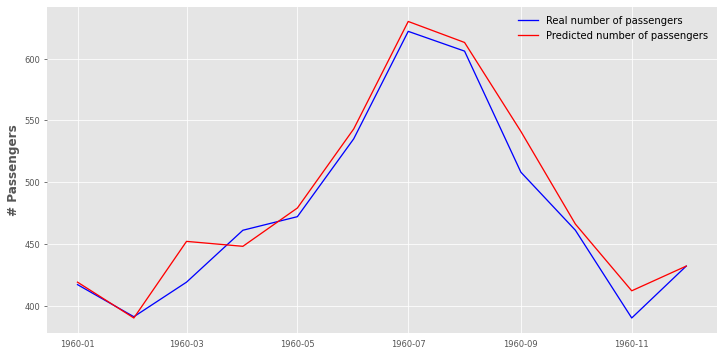

In [21]:
plt.figure(figsize=(12,6))
plt.plot(df_test['#Passengers'], color='b', label='Real number of passengers')
plt.plot(df_test['prediction'], color='r', label='Predicted number of passengers')
plt.ylabel('# Passengers')
plt.legend()
plt.show()

In [24]:
df_test['diff'] = abs(df_test['#Passengers'] - df_test['prediction'])

df_test

,#Passengers,prediction,diff
Month,,,
1960-01-01,417,419,2
1960-02-01,391,390,1
1960-03-01,419,452,33
1960-04-01,461,448,13
1960-05-01,472,479,7
1960-06-01,535,543,8
1960-07-01,622,630,8
1960-08-01,606,613,7
1960-09-01,508,541,33


## Podsumowanie

W niniejszym zadaniu wykonana została predykcja szeregu czasowego. Wykorzystanym zbiorem danych jest [Airline Passengers](https://www.kaggle.com/chirag19/air-passengers).

Po wczytaniu danych, podzielono je na część treningową i walidacyjną. Zgodnie z zaleceniem, predykcję wykonano dla ostatnich dwunastu wartości (niewykorzystywanych w procesie analizy danych i do treningu).

Przeprowodono szereg wizualizacji badanego szeregu czasowego w celu zapoznania się z charakterystyką danych. Analizie poddano również wyniki funkcji ACF i PACF. W autokorelogramie (ACF) dostrzegalne jest lokalne ekstremum maksymalne w okolicach LAG 12. Oznacza to, że co 12 próbek następuje wzrost korelacji, czyli występuje sezonowość o okresie roku (jako, że kolejne odczyty dotyczą kolejnych miesięcy - granulacja miesięczna). W autokorelogramie częściowym (PACF) widać wysoką korelację tylko w okolicach próbek LAG 0 i 1 oraz niewielką korelację ujemną dla LAG 2 i 12.

W celu wykonania predykcji, wykorzystano stworzoną przy pomocy biblioteki Keras sieć neuronową, z jedną warstwą LSTM (50 jednostek; aktywacja ReLU). Sieć wytrenowana została na odpowiednio przygotowanym zbiorze treningowym przez okres 250 epok. Konkretne ustawienie modelu zostało dobrane poprzez eksplorację przestrzeni parametrów architektury i hiperparametrów modelu. Wykorztsne metryki to: RMSE MAE i MPAE.

W ten sposób przygotowany model stosunkowo dobrze poradził sobie z zadaniem predykcji 12 kolejnych próbek szeregu. Dodatkowo, jako wizualizacja wyników, na ostatnich dwóch ilustracjach nałożone na wykresy zostały wartości przewidywane oraz faktyczne.